# Introduction to control theory. 

## TP5. State Observers. LQ.
## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP4.ipynb)    

The completed notebook should be **submitted via the corresponding Moodle assignment before the beginning of the next session.**

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

    5. Control System Library https://python-control.readthedocs.io/en/0.10.1/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html




## TODO

Last time you designed a full-state feedback controller $u=-Kx, $ which stabilizes the system in steady state
$x = (0,0,0,0).$

0. If you have not done this - do it today! And don't hesitate to ask questions if it is unclear.

This time let us assume that we only measure the position and the angular velocity, while their derivatives are not availabe. I.e. $y_{output} = (y, \theta)' = Cx,$ where 
$$C = \begin{pmatrix} 1 & 0 & 0 &0 \\ 0 & 0 & 1 &0 \end{pmatrix}$$

1. Is the pair of matrices (A,C) observable? Why is this important? 

2. For an autonomous system
$$
\dot x = Ax, \ y = Cx
$$

design an observer $$\dot{\hat{x}} = (A - LC)\hat{x} + Ly,$$ such that the estimation of the state $\hat{x}$ converges to real state $x$. To do that, we need to find a matrice $L$ such that the matrice $A-LC$ is Hurwitz (i.e., all its eigenvalues have a negative real part). 

**Remark:** to place arbitary eigenvalues $\lambda_1,\ldots \lambda_n$ in matrice (A - LC) with matrice L, it is the same as to place $\lambda_1,\ldots \lambda_n$ in matrice $(A^T - C^TL^T)$ with matrice $L^T$. 

Plot a real trajectory $x$ starting from the point $x_0 = (2,0,1,0)$ and its estimation $\hat{x}$ starting from the point $\hat{x}_0 = (3,-1,2,0.5)$ to show convergence.

3. Design an optimal estimator (LQE) and an optimal estimated-state-feedback controller (LQR), which stabilizes the system in (0,0,0,0).

**Remark:** See slide "observer and controller" in the lecture.

## Answer TODO 0

A stabilizing full-state feedback of the form u = -Kx is required for the undisturbed linear model (w(t)=0), so that the equilibrium x = (0,0,0,0) is asymptotically stable. A simple pole placement is used: K is computed so that the eigenvalues of A - BK are -1, -2, -3, -4. With these poles in the left half-plane, the closed-loop trajectories converge to zero.

In [1]:
import numpy as np
from scipy.signal import place_poles

# Linearized cart-pole model (same parameters as in TP4)
M = 0.5
m = 0.2
b = 0.1
l = 0.3
I = 0.006
g = 9.81

p = I + m * l**2
Delta = (M + m) * p - (m * l) ** 2

A = np.array([
    [0.0, 1.0, 0.0, 0.0],
    [0.0, -(p * b) / Delta, -(m**2 * g * l**2) / Delta, 0.0],
    [0.0, 0.0, 0.0, 1.0],
    [0.0, (m * l * b) / Delta, ((M + m) * m * g * l) / Delta, 0.0],
])
B = np.array([[0.0], [p / Delta], [0.0], [-(m * l) / Delta]])

desired_poles = np.array([-1.0, -2.0, -3.0, -4.0])
K = place_poles(A, B, desired_poles).gain_matrix
Acl = A - B @ K

print("K =", K)
print("eig(A - B K) =", np.sort_complex(np.linalg.eigvals(Acl)))

K = [[ -0.5382263   -1.22130479 -14.78229052  -2.64852192]]
eig(A - B K) = [-4.+0.j -3.+0.j -2.+0.j -1.+0.j]


## Answer TODO 1
Given the output y = Cx with measurements of the cart position y and the pendulum angle theta, observability of the pair (A,C) determines whether the full state x can be reconstructed from the output. For this model and the given C, the observability matrix has full rank (rank(O)=4), hence (A,C) is observable. This is important because it guarantees that an observer (Luenberger or LQE) can be designed by choosing L so that A - LC is Hurwitz, which makes the estimation error converge to zero; without observability, some state components cannot be recovered from y.

In [3]:
# Observability check for (A, C)
C = np.array([[1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.0]])

n = A.shape[0]
O = C
for k in range(1, n):
    O = np.vstack([O, C @ np.linalg.matrix_power(A, k)])

print("rank(O) =", np.linalg.matrix_rank(O), "(n =", n, ")")

rank(O) = 4 (n = 4 )


## Answer TODO 2
The Luenberger observer is $\dot{\hat x} = A\hat x + Bu + L(y - C\hat x)$ with $y = Cx$. The estimation error $e = x - \hat x$ follows $\dot e = (A - LC)e$, so choosing $L$ such that $A - LC$ is Hurwitz guarantees $e(t) \to 0$ exponentially. Since the open-loop matrix $A$ is unstable in this model, the trajectories $x(t)$ and $\hat x(t)$ can grow very large over time; this does not contradict good estimation, because the correct convergence check is the decay of $e(t)$. After the error becomes extremely small, any small oscillations visible on a log plot are only due to numerical precision limits, not a real loss of convergence.

eig(A - L C) = [-8.+0.j -7.+0.j -6.+0.j -5.+0.j]


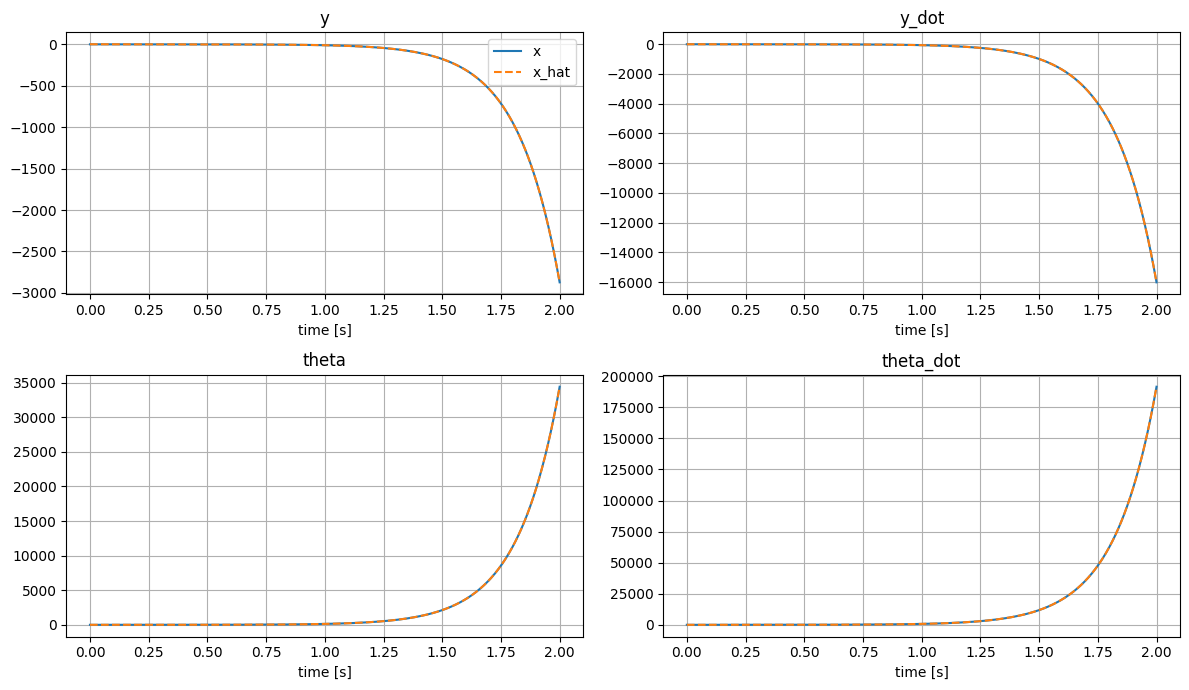

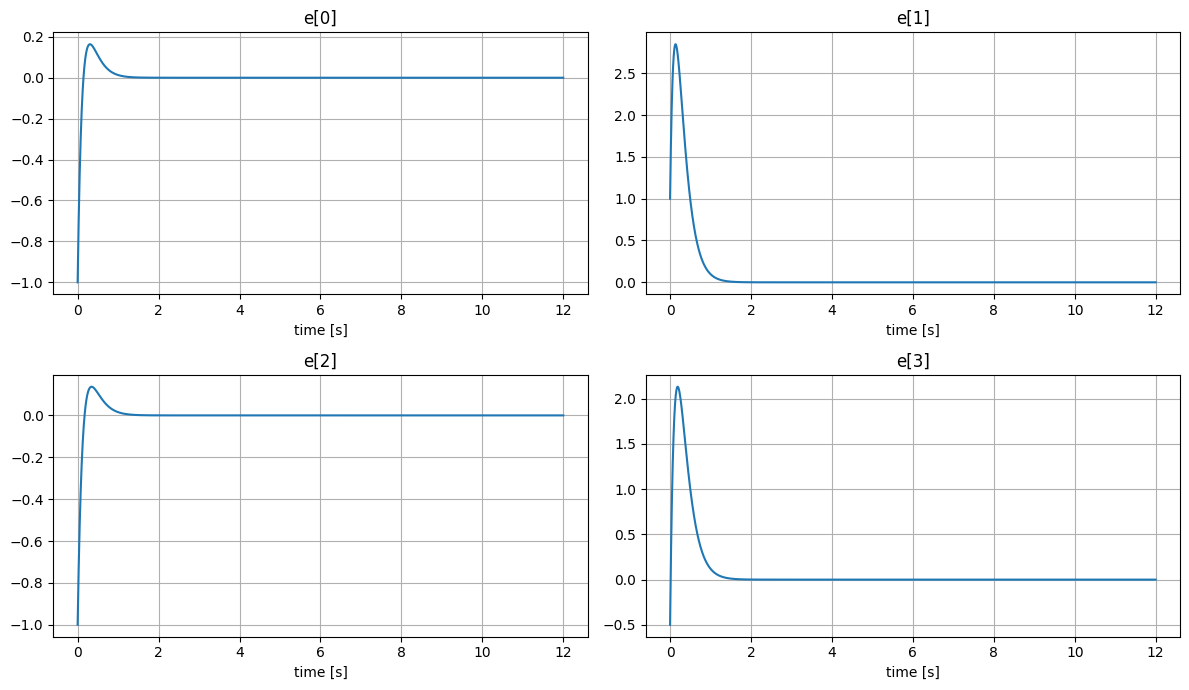

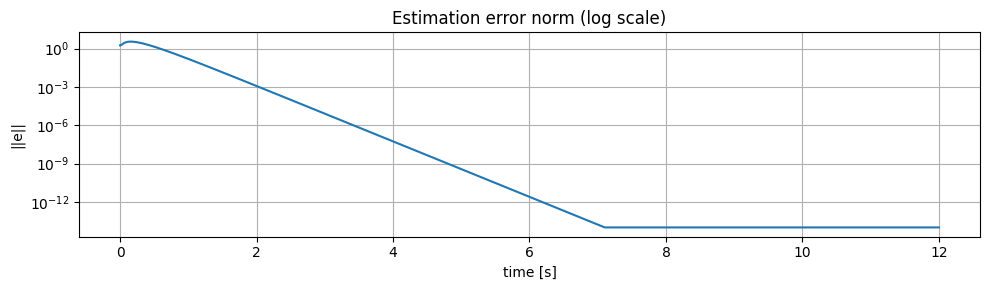

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import place_poles
from scipy.sparse.linalg import expm_multiply

# Output matrix from the statement
C = np.array([[1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.0]])

# Observer gain via pole placement on (A^T, C^T)
observer_poles = np.array([-5.0, -6.0, -7.0, -8.0])
L = place_poles(A.T, C.T, observer_poles).gain_matrix.T

Aobs = A - L @ C
print("eig(A - L C) =", np.sort_complex(np.linalg.eigvals(Aobs)))

# Initial conditions from the statement
x0 = np.array([2.0, 0.0, 1.0, 0.0])
xhat0 = np.array([3.0, -1.0, 2.0, 0.5])
e0 = x0 - xhat0

# Time grids
t_short = (0.0, 2.0)   # short window: makes x vs x_hat readable even if A is unstable
t_long = (0.0, 12.0)   # longer window: shows exponential decay of the error
T_short = np.linspace(*t_short, 800)
T_long = np.linspace(*t_long, 2400)

# Exact trajectories using matrix exponentials
x = expm_multiply(A, x0, start=t_short[0], stop=t_short[1], num=len(T_short), endpoint=True)
e = expm_multiply(Aobs, e0, start=t_long[0], stop=t_long[1], num=len(T_long), endpoint=True)
e_short = expm_multiply(Aobs, e0, start=t_short[0], stop=t_short[1], num=len(T_short), endpoint=True)

# Reconstruct x_hat on the short window using x_hat = x - e
xhat = x - e_short

plt.figure(figsize=(12, 7))
labels = ["y", "y_dot", "theta", "theta_dot"]
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    ax.plot(T_short, x[:, i], label="x")
    ax.plot(T_short, xhat[:, i], "--", label="x_hat")
    ax.set_title(labels[i])
    ax.set_xlabel("time [s]")
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()

plt.figure(figsize=(12, 7))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    ax.plot(T_long, e[:, i])
    ax.set_title(f"e[{i}]")
    ax.set_xlabel("time [s]")
    ax.grid(True)

plt.tight_layout()

e_norm = np.linalg.norm(e, axis=1)
e_norm_plot = np.clip(e_norm, 1e-14, None)  # numerical floor for log scale
plt.figure(figsize=(10, 3))
plt.semilogy(T_long, e_norm_plot)
plt.grid(True, which="both")
plt.xlabel("time [s]")
plt.ylabel("||e||")
plt.title("Estimation error norm (log scale)")
plt.tight_layout()

## Answer TODO 3
A dynamic output-feedback controller can be obtained by combining an LQR state-feedback law with a Luenberger observer. The LQR gain $K$ is computed to stabilize the state-feedback closed loop and to minimize a quadratic cost, while the observer gain $L$ is chosen (for instance by pole placement) to make $A - LC$ Hurwitz so that the estimation error converges exponentially. The implemented controller uses the estimated-state feedback $u = -K\hat x$, with the observer driven by the measured output $y = Cx$.

eig(A - B K_lqr) = [-7.59356799-3.84234591j -7.59356799+3.84234591j -1.06346674-0.90331497j
 -1.06346674+0.90331497j]
eig(A - L C) = [-8.+0.j -7.+0.j -6.+0.j -5.+0.j]


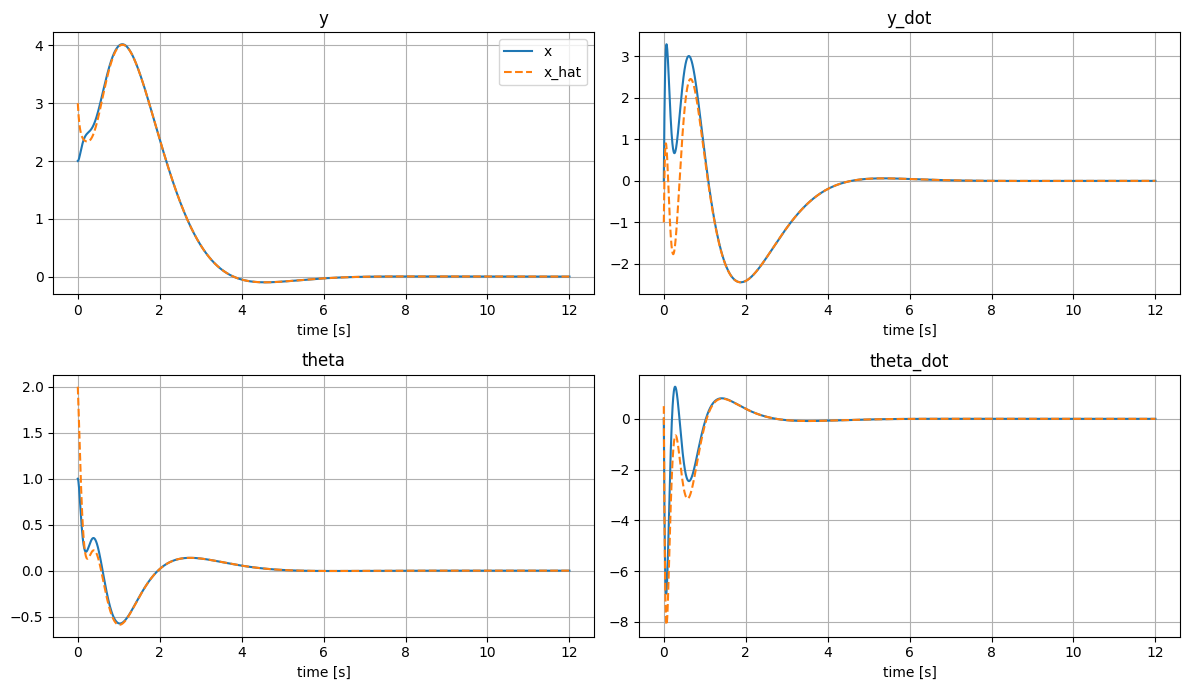

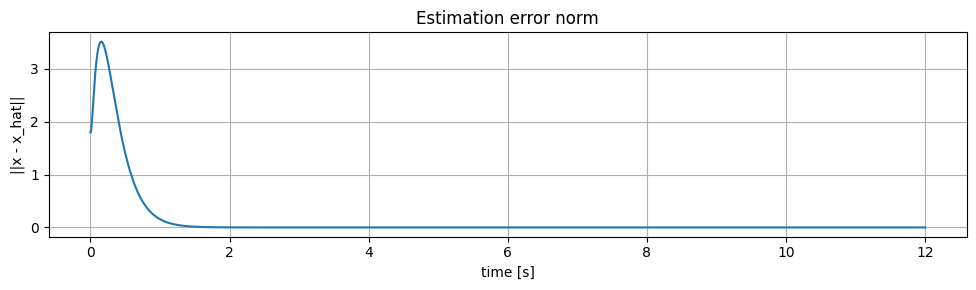

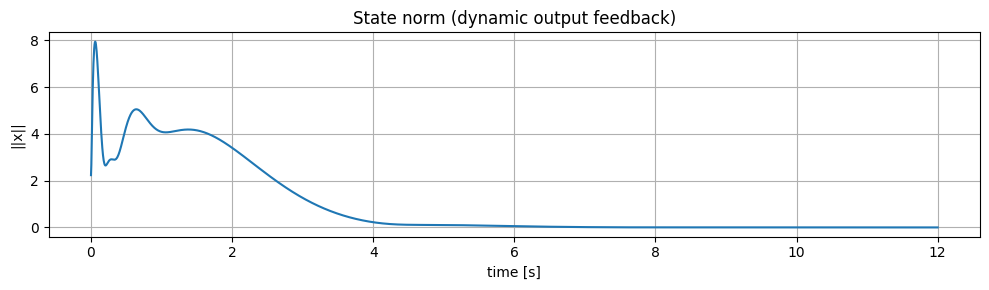

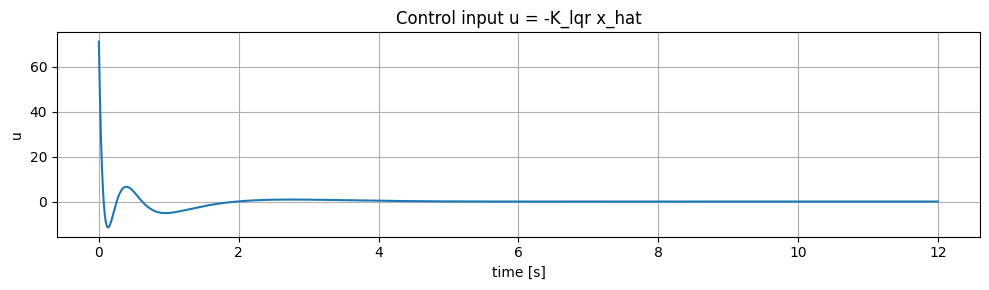

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.linalg import solve_continuous_are
from scipy.signal import place_poles

# Matrices A, B are defined above (TODO 0).
# C is re-defined here to keep this cell standalone.
C = np.array([[1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.0]])

# LQR design: minimize integral (x^T Q x + u^T R u) dt
Q = np.diag([10.0, 1.0, 200.0, 1.0])
R = np.array([[1.0]])

P = solve_continuous_are(A, B, Q, R)
K_lqr = np.linalg.solve(R, B.T @ P)  # R^{-1} B^T P

Acl_lqr = A - B @ K_lqr
print("eig(A - B K_lqr) =", np.sort_complex(np.linalg.eigvals(Acl_lqr)))

# Luenberger observer gain via pole placement on (A^T, C^T)
observer_poles = np.array([-5.0, -6.0, -7.0, -8.0])
L = place_poles(A.T, C.T, observer_poles).gain_matrix.T
Aobs = A - L @ C
print("eig(A - L C) =", np.sort_complex(np.linalg.eigvals(Aobs)))

# Dynamic output-feedback implementation
# Plant:       x_dot    = A x + B u,    y = C x
# Observer:    xhat_dot = A xhat + B u + L (y - C xhat)
# Control law: u = -K_lqr xhat
x0 = np.array([2.0, 0.0, 1.0, 0.0])
xhat0 = np.array([3.0, -1.0, 2.0, 0.5])
z0 = np.concatenate([x0, xhat0])

def closed_loop_observer_rhs(z, t):
    x = z[:4]
    xhat = z[4:]
    u = -K_lqr @ xhat
    y = C @ x
    dx = (A @ x + (B @ u).flatten())
    dxhat = (A @ xhat + (B @ u).flatten() + (L @ (y - C @ xhat)).flatten())
    return np.concatenate([dx, dxhat])

t0, tf = 0.0, 12.0
T = np.linspace(t0, tf, 2400)
sol = odeint(closed_loop_observer_rhs, z0, T)
x = sol[:, :4]
xhat = sol[:, 4:]
e = x - xhat
u_traj = np.array([(-K_lqr @ xhat[i, :]).item() for i in range(xhat.shape[0])])

plt.figure(figsize=(12, 7))
labels = ["y", "y_dot", "theta", "theta_dot"]
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    ax.plot(T, x[:, i], label="x")
    ax.plot(T, xhat[:, i], "--", label="x_hat")
    ax.set_title(labels[i])
    ax.set_xlabel("time [s]")
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()

plt.figure(figsize=(10, 3))
plt.plot(T, np.linalg.norm(e, axis=1))
plt.grid(True)
plt.xlabel("time [s]")
plt.ylabel("||x - x_hat||")
plt.title("Estimation error norm")
plt.tight_layout()

plt.figure(figsize=(10, 3))
plt.plot(T, np.linalg.norm(x, axis=1))
plt.grid(True)
plt.xlabel("time [s]")
plt.ylabel("||x||")
plt.title("State norm (dynamic output feedback)")
plt.tight_layout()

plt.figure(figsize=(10, 3))
plt.plot(T, u_traj)
plt.grid(True)
plt.xlabel("time [s]")
plt.ylabel("u")
plt.title("Control input u = -K_lqr x_hat")
plt.tight_layout()